In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from scipy.spatial.distance import cdist

In [3]:
df = pd.read_csv("final_data.csv")
df.head()

,ProductID,ProductName,Category,CustomerID,CustomerName,Region,SignupDate,TransactionID,TransactionDate,Quantity,TotalValue,Price,CalculatedValue,Month,Year,Month_Year,Day,Day_Name
0,P001,ActiveWear Biography,Books,C0017,Jennifer King,Europe,2023-12-05,T00758,2024-05-28 14:47:15,3,507.9,169.3,507.9,5,2024,2024-05,2,Tuesday
1,P001,ActiveWear Biography,Books,C0019,Brandon Rodriguez,Europe,2023-01-12,T00088,2024-01-30 17:23:03,2,338.6,169.3,338.6,1,2024,2024-01,2,Tuesday
2,P001,ActiveWear Biography,Books,C0024,Michele Cooley,North America,2024-02-05,T00314,2024-09-24 17:15:16,4,677.2,169.3,677.2,9,2024,2024-09,2,Tuesday
3,P001,ActiveWear Biography,Books,C0036,Brian Aguilar DDS,North America,2024-07-06,T00433,2024-05-05 05:01:18,2,338.6,169.3,338.6,5,2024,2024-05,0,Sunday
4,P001,ActiveWear Biography,Books,C0045,Michael Williams,Asia,2022-02-25,T00732,2024-08-13 10:42:48,2,338.6,169.3,338.6,8,2024,2024-08,2,Tuesday


In [4]:
customer_features = df.groupby("CustomerID").agg({
    "TotalValue": "sum",
    "Quantity": "sum",
    "Region": "first",  # Categorical
    "Category": "first",  # Categorical
    "SignupDate": "first"  # Convert to numerical later
}).reset_index()

In [5]:
customer_features["SignupDate"] = pd.to_datetime(customer_features["SignupDate"])
customer_features["SignupDays"] = (pd.to_datetime('today') - customer_features["SignupDate"]).dt.days

# Encode categorical variables
le_region = LabelEncoder()
customer_features["Region"] = le_region.fit_transform(customer_features["Region"])

le_category = LabelEncoder()
customer_features["Category"] = le_category.fit_transform(customer_features["Category"])

# Select features for clustering
features = ["TotalValue", "Quantity", "Region", "Category", "SignupDays"]
X = customer_features[features]

# Standardize data for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

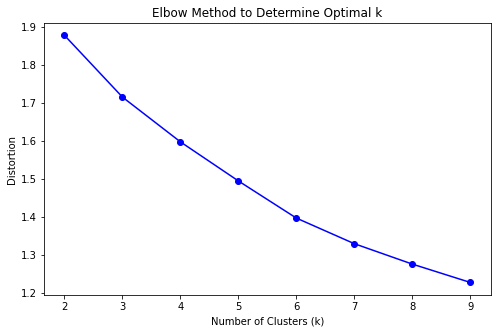

In [6]:
# Use the Elbow Method to determine optimal clusters
distortions = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    distortions.append(sum(np.min(cdist(X_scaled, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X_scaled.shape[0])

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K, distortions, 'bo-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Distortion")
plt.title("Elbow Method to Determine Optimal k")
plt.show()


In [11]:
optimal_clusters = 6
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features["Cluster"] = kmeans.fit_predict(X_scaled)

In [12]:
# Compute Clustering Metrics
db_index = davies_bouldin_score(X_scaled, customer_features["Cluster"])
silhouette_avg = silhouette_score(X_scaled, customer_features["Cluster"])

print(f"Davies-Bouldin Index: {db_index:.4f}")  # Lower is better
print(f"Silhouette Score: {silhouette_avg:.4f}")  # Higher is better


Davies-Bouldin Index: 1.3340
Silhouette Score: 0.2235


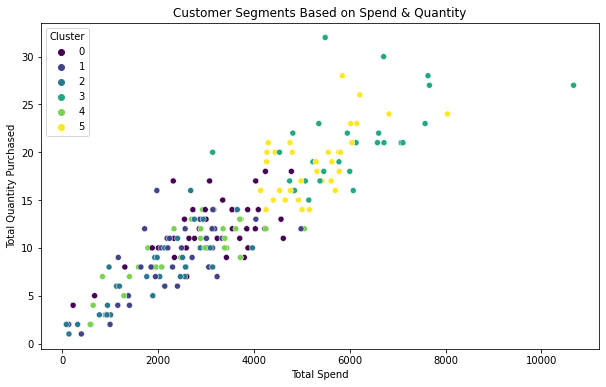

In [13]:
# Visualize clusters with scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=customer_features["TotalValue"], 
                y=customer_features["Quantity"], 
                hue=customer_features["Cluster"], 
                palette="viridis")

plt.xlabel("Total Spend")
plt.ylabel("Total Quantity Purchased")
plt.title("Customer Segments Based on Spend & Quantity")
plt.legend(title="Cluster")
plt.show()


In [14]:
# Save clustered customer data
customer_features.to_csv("segmented_customers.csv", index=False)
